In [1]:
import sqlite3
import pandas as pd
import numpy as np
import os
import polars as pl

import random
random.seed(42)

import sys

sys.path.append('../')
from src.feat_network import get_edge_node_table, filter_edge_table
from src.feat_visualization import sygma_graph
from src.datamodel import OptimumParameter
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score
from dotenv import load_dotenv
import scipy.stats as stats


In [2]:
# Load the environment variables from the .env file
dotenv_path = os.path.join('../', '.env')
load_dotenv(dotenv_path)

True

In [3]:
conn_full_db = sqlite3.connect(os.getenv("FULL_DB_PATH"))
conn = sqlite3.connect("../database.db")

df_ind_regions = pd.read_sql_query(
        "SELECT * FROM individuals_regions", conn_full_db
    )
df_ind_regions = df_ind_regions.rename(
        columns={"individual_wikidata_id": "wikidata_id"}
    )

In [4]:
df_occupation = pd.read_sql("SELECT * FROM individual_id_cleaned_occupations", conn)
df_indi = pd.merge(df_ind_regions, df_occupation, on = 'wikidata_id')
df_indi = df_indi[['wikidata_id', 'region_code']].drop_duplicates()
df_region_count = df_indi.groupby('region_code')['wikidata_id'].count().rename('count_individuals').reset_index()

In [5]:
df_baseline = pd.read_sql("SELECT * FROM optimal_partition", conn)
df_baseline = df_baseline.rename(columns = {'community':'community_baseline'})

df_region_parition = pd.read_sql("SELECT * FROM region_optimized_partition", conn)




In [6]:
pivot_df = df_region_parition.pivot_table(index='node', columns='region_code', values='community', fill_value=np.nan)
#new_columns = ['community_' + region for region in pivot_df.columns]
#pivot_df.columns = new_columns
pivot_df = pivot_df.reset_index()
df = pd.merge(df_baseline, pivot_df, on = 'node')
df = df.set_index('node')

baseline_community = list(df['community_baseline'])

fina_list = []
for col in df.columns:
    
    #new_df = df[['community_baseline', col]].dropna()
    new_df = df[['community_baseline', col]].fillna(3)

    ari = adjusted_rand_score(list(new_df[col]), list(new_df['community_baseline']))
    fina_list.append({'region':col, 'ari_baseline':ari})
    
df_region_ari = pd.DataFrame(fina_list)
df_region_ari = df_region_ari.sort_values('ari_baseline', ascending=False)
df_region_ari = df_region_ari.reset_index(drop=True)

In [7]:
pd.options.mode.chained_assignment = None

In [8]:

regions = list(df_region_count['region_code'])
count_individuals = list(df_region_count['count_individuals'])

dict_regions_count = {x: y for x, y in zip(regions, count_individuals)}

In [9]:
all_regions = list(df_region_count.region_code)
all_individuals = list(set(df_occupation.wikidata_id))

In [10]:

optimal_parameters = pd.read_sql("SELECT * FROM optimization", conn)
optimal_parameters = optimal_parameters.sort_values("mean", ascending=False)

dict_op = optimal_parameters.iloc[0].to_dict()
dict_op = OptimumParameter(**dict_op)

In [11]:
directory = "../cache"
if not os.path.exists(directory):
    os.makedirs(directory)

In [12]:
final_clustering= []
all_regions = list(df_region_count.region_code)
for region_code in tqdm(all_regions):
    
    random_clustering = []
    for seed in np.arange(20):
        random.seed(seed)    
        try:

            # take a sample of individuals as big as the region
            sample_len = dict_regions_count.get(region_code)
            sample_ids = random.sample(all_individuals, sample_len)
            df_sample = df_occupation[df_occupation['wikidata_id'].isin(sample_ids)]
            df_sample.columns = ["source", "target"]
            df_sample["weight"] = 1

            # Draw the graph
            df_sample = pl.from_pandas(df_sample)

            df_edge, df_nodes = get_edge_node_table(df_sample)

            df_edge_filter = filter_edge_table(
                df_edge,
                edge_rule=dict_op.edge_rule,
                top_directed_neighbours=dict_op.n_neighbours,
                normalize_on_top=False,
                min_count_link=0,
            )

            df_partition = sygma_graph(
                df_edge_filter,
                df_nodes,
                edge_bins=10,
                node_bins=10,
                resolution=dict_op.resolution,
                filepath="../cache/cache_graph.html",
            )    

            df_partition = df_partition.rename(columns = {'community':f'community_{seed}'})
            random_clustering.append(df_partition)

        except:
            pass
        
    merged_df = random_clustering[0]
    for table in random_clustering[1:]:
        merged_df = pd.merge(merged_df, table, on=["node"], how = 'outer')
    merged_df = merged_df.set_index("node")
    merged_df['region_code'] = region_code
    final_clustering.append(merged_df)


100%|█████████████████████████████████████████████████████████████| 53/53 [08:44<00:00,  9.90s/it]


In [18]:
df_final_clustering = pd.concat([x for x in final_clustering])

In [113]:
region_code = 're_france'

final_sample = []
for region_code in df_final_clustering.region_code.unique():

    df_merge = df_final_clustering[df_final_clustering['region_code']==region_code]
    df_merge = pd.merge(df_baseline, df_merge, on = 'node', how ='outer')
    df_merge = df_merge.set_index('node')
    df_merge = df_merge.drop('region_code', axis=1)

    baseline_community = list(df_merge['community_baseline'])

    final_list = []
    for col in df_merge.columns:

        #new_df = df_sample_ari[['community_baseline', col]].dropna()
        new_df = df_merge[['community_baseline', col]].fillna(4)
        ari = adjusted_rand_score(list(new_df[col]), list(new_df['community_baseline']))
        final_list.append({'sample_type':col, 'ari_baseline_random':ari})

    df_final_list = pd.DataFrame(final_list)
    df_final_list['region'] = region_code
    final_sample.append(df_final_list)
    
df_final_sample = pd.concat([x for x in final_sample])

In [114]:
# moyenne des différence entre la distance au hasard et la distance à la baseline

In [119]:
columns_to_keep = [
        "re_arabic_world",
        "re_central_europe",
        "re_chinese_world",
        "re_eastern_europe",
        "re_france",
        "re_german_world",
        "re_greek_world",
        "re_indian_world",
        "re_italy",
        "re_japan",
        "re_low_countries",
        "re_nordic_countries",
        "re_persian_world",
        "re_slav_world",
        "re_spain",
        "re_united_kingdom",
    ]

df_t_test = df_diff.groupby(['region', 'ari_baseline'])['ari_baseline_random'].mean().rename('mean_ari_baseline_random').reset_index()
df_t_test = df_t_test[df_t_test['region'].isin(columns_to_keep)]

# faire le t-test: est-ce qu'il y a une différnece significative ? 

# Perform the t-test

t_statistic, p_value = stats.ttest_ind(list(df_t_test['ari_baseline']), list(df_t_test['mean_ari_baseline_random']))

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 0.046346591671557726
P-Value: 0.9633411549294573


In [120]:
df_t_test.head(5)

,region,ari_baseline,mean_ari_baseline_random
1,re_arabic_world,0.249374,0.375460
6,re_central_europe,0.437051,0.503382
7,re_chinese_world,0.041957,0.250053
9,re_eastern_europe,0.642383,0.514882
11,re_france,0.651577,0.483231


<AxesSubplot: >

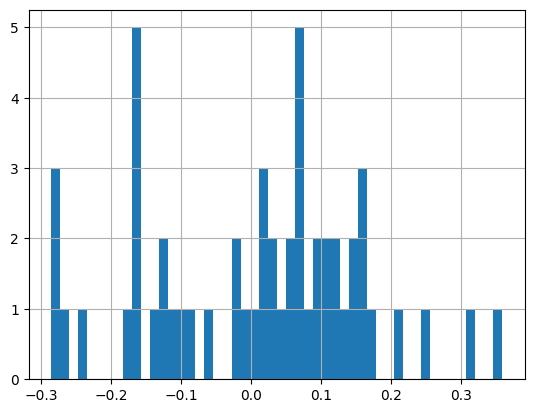

In [121]:
df_diff = pd.merge(df_final_sample, df_region_ari, on = 'region')
df_diff = df_diff[df_diff['sample_type']!= 'community_baseline']
df_diff['diff'] = df_diff['ari_baseline_random'] - df_diff['ari_baseline']
#df_diff['diff'] = df_diff['diff'].abs()
df_diff_final = df_diff.groupby('region')['diff'].mean().rename('mean_diff').reset_index()
df_diff_final = df_diff_final.sort_values('mean_diff', ascending=False).reset_index(drop=True)

# difference positive: plus proche de la baseline que le hasard
# forces négatives: c'est encore plus différent

df_diff_final.mean_diff.hist(bins = 50)

#### Correlation with Size

In [122]:
df_diff_size = df_diff.copy()
df_diff_size['ari_baseline_random'] = df_diff_size['ari_baseline_random'].abs()
df_diff_size = df_diff_size.groupby(['region'])['ari_baseline_random'].mean().reset_index()
df_diff_size = df_diff_size.rename(columns = {'region':'region_code'})

df_region_size = df_ind_regions[['wikidata_id', 'region_code']].drop_duplicates()
df_region_size = df_region_size.groupby('region_code')['wikidata_id'].count().rename('region_size').reset_index()


df_size = pd.merge(df_diff_size, df_region_size, on = 'region_code')
df_size = df_size[df_size['region_code'].isin(columns_to_keep)]
df_size = df_size.set_index('region_code')
df_size = df_size.sort_values('region_size')
df_size.corr()

# plus c'est grand, plus c'est similaire à la structure globale

,ari_baseline_random,region_size
ari_baseline_random,1.000000,0.618471
region_size,0.618471,1.000000
